<a href="https://colab.research.google.com/github/rajkumar2698/Nutrition_Paradox/blob/main/Nutrition__Paradox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd

urls = {
   "adult_obesity": "https://ghoapi.azureedge.net/api/NCD_BMI_30C",
   "child_obesity": "https://ghoapi.azureedge.net/api/NCD_BMI_PLUS2C",
   "adult_malnutrition": "https://ghoapi.azureedge.net/api/NCD_BMI_18C",
   "child_malnutrition": "https://ghoapi.azureedge.net/api/NCD_BMI_MINUS2C"
}

def fetch_data(url):
  response = requests.get(url)
  data = response.json()['value']
  return pd.DataFrame(data)

df_adult_obesity = fetch_data(urls["adult_obesity"])
df_child_obesity = fetch_data(urls["child_obesity"])
df_adult_malnutrition = fetch_data(urls["adult_malnutrition"])
df_child_malnutrition = fetch_data(urls["child_malnutrition"])
print("Data successfully loaded!")

Data successfully loaded!


In [2]:

df_adult_obesity["age_group"] = "Adult"
df_child_obesity["age_group"] = "Child/Adolescent"
df_adult_malnutrition["age_group"] = "Adult"
df_child_malnutrition["age_group"] = "Child/Adolescent"

df_obesity = pd.concat([df_adult_obesity, df_child_obesity], ignore_index=True)
df_malnutrition = pd.concat([df_adult_malnutrition, df_child_malnutrition], ignore_index=True)


In [3]:
df_obesity = df_obesity[df_obesity["TimeDim"].between(2012, 2022)]
df_malnutrition = df_malnutrition[df_malnutrition["TimeDim"].between(2012, 2022)]


In [4]:
cols = ["ParentLocation","Dim1","TimeDim","Low","High","NumericValue","SpatialDim","age_group"]

def clean_df(df):
    df = df[cols].copy()
    df.rename(columns={
        "TimeDim":"Year",
        "Dim1":"Gender",
        "NumericValue":"Mean_Estimate",
        "Low":"LowerBound",
        "High":"UpperBound",
        "ParentLocation":"Region",
        "SpatialDim":"Country"
    }, inplace=True)
    return df

df_obesity = clean_df(df_obesity)
df_malnutrition = clean_df(df_malnutrition)


In [5]:
gender_map = {
    "SEX_MLE": "Male",
    "SEX_FMLE": "Female",
    "SEX_BTSX": "Both"
}

df_obesity["Gender"] = df_obesity["Gender"].map(gender_map)
df_malnutrition["Gender"] = df_malnutrition["Gender"].map(gender_map)


In [6]:
%pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 50.0 MB/s eta 0:00:00


In [7]:
import pycountry

def convert_country(code):
    try:
        country = pycountry.countries.get(alpha_3=code)
        return country.name if country else code
    except:
        return code


In [8]:
special_cases = {
    'GLOBAL': 'Global',
    'WB_LMI': 'Low & Middle Income',
    'WB_HI': 'High Income',
    'WB_LI': 'Low Income',
    'EMR': 'Eastern Mediterranean Region',
    'EUR': 'Europe',
    'AFR': 'Africa',
    'SEAR': 'South-East Asia Region',
    'WPR': 'Western Pacific Region',
    'AMR': 'Americas Region',
    'WB_UMI': 'Upper Middle Income'
}


In [9]:
#Special Case Convertion
df_obesity["Country"] = df_obesity["Country"].apply(convert_country)
df_malnutrition["Country"] = df_malnutrition["Country"].apply(convert_country)

df_obesity["Country"] = df_obesity["Country"].replace(special_cases)
df_malnutrition["Country"] = df_malnutrition["Country"].replace(special_cases)


In [10]:
df_obesity["CI_Width"] = df_obesity["UpperBound"] - df_obesity["LowerBound"]
df_malnutrition["CI_Width"] = df_malnutrition["UpperBound"] - df_malnutrition["LowerBound"]


In [11]:
def categorize_obesity(val):
    if val >= 30:
        return "High"
    elif val >= 25:
        return "Moderate"
    else:
        return "Low"


def categorize_malnutrition(val):
    if val >= 20:
        return "High"
    elif val >= 10:
        return "Moderate"
    else:
        return "Low"


df_obesity["Obesity_Level"] = df_obesity["Mean_Estimate"].apply(categorize_obesity)
df_malnutrition["Malnutrition_Level"] = df_malnutrition["Mean_Estimate"].apply(categorize_malnutrition)


In [16]:
#Unknown
df_obesity["Region"] = df_obesity["Region"].fillna("Unknown")
df_malnutrition["Region"] = df_malnutrition["Region"].fillna("Unknown")


In [17]:
df_obesity = df_obesity[
    [
        "Year",
        "Gender",
        "Mean_Estimate",
        "LowerBound",
        "UpperBound",
        "age_group",
        "Country",
        "Region",
        "CI_Width",
        "Obesity_Level"
    ]
]


df_malnutrition = df_malnutrition[
    [
        "Year",
        "Gender",
        "Mean_Estimate",
        "LowerBound",
        "UpperBound",
        "age_group",
        "Country",
        "Region",
        "CI_Width",
        "Malnutrition_Level"
    ]
]



print(df_obesity.head())
print(df_malnutrition.head())

   Year  Gender  Mean_Estimate  LowerBound  UpperBound age_group  \
0  2020    Both       7.587976    7.045677    8.160195     Adult   
2  2021  Female      16.798417   14.229935   19.655068     Adult   
3  2014    Male      19.599763   16.816987   22.484732     Adult   
5  2019    Male      20.532216   17.483680   23.878790     Adult   
7  2022    Both       4.935368    4.128999    5.799731     Adult   

                  Country           Region  CI_Width Obesity_Level  
0  Western Pacific Region          Unknown  1.114518           Low  
2                Slovenia           Europe  5.425133           Low  
3    Moldova, Republic of           Europe  5.667745           Low  
5                 Belgium           Europe  6.395110           Low  
7                   Japan  Western Pacific  1.670732           Low  
    Year  Gender  Mean_Estimate  LowerBound  UpperBound age_group  \
0   2018    Both       3.942757    2.910176    5.165938     Adult   
2   2018  Female       1.577565    0.80

In [18]:
#Final verification and export to CSV (Power BI ready)

# -------- 1. Check final columns --------
print("Obesity columns:", df_obesity.columns)
print("Malnutrition columns:", df_malnutrition.columns)

# -------- 2. Check column count --------
print("Obesity column count:", df_obesity.shape[1])
print("Malnutrition column count:", df_malnutrition.shape[1])

# -------- 3. Preview final data --------
print(df_obesity.head())
print(df_malnutrition.head())

# -------- 4. Export to CSV --------
df_obesity.to_csv("df_obesity_final.csv", index=False)
df_malnutrition.to_csv("df_malnutrition_final.csv", index=False)

print("CSV files exported successfully!")


Obesity columns: Index(['Year', 'Gender', 'Mean_Estimate', 'LowerBound', 'UpperBound',
       'age_group', 'Country', 'Region', 'CI_Width', 'Obesity_Level'],
      dtype='object')
Malnutrition columns: Index(['Year', 'Gender', 'Mean_Estimate', 'LowerBound', 'UpperBound',
       'age_group', 'Country', 'Region', 'CI_Width', 'Malnutrition_Level'],
      dtype='object')
Obesity column count: 10
Malnutrition column count: 10
   Year  Gender  Mean_Estimate  LowerBound  UpperBound age_group  \
0  2020    Both       7.587976    7.045677    8.160195     Adult   
2  2021  Female      16.798417   14.229935   19.655068     Adult   
3  2014    Male      19.599763   16.816987   22.484732     Adult   
5  2019    Male      20.532216   17.483680   23.878790     Adult   
7  2022    Both       4.935368    4.128999    5.799731     Adult   

                  Country           Region  CI_Width Obesity_Level  
0  Western Pacific Region          Unknown  1.114518           Low  
2                Slovenia   

In [19]:
df_obesity.to_csv("df_obesity_final.csv", index=False)
df_malnutrition.to_csv("df_malnutrition_final.csv", index=False)

In [20]:
df_obesity.to_csv(r"C:\Users\Public\Desktop\df_obesity_final.csv", index=False)
df_malnutrition.to_csv(r"C:\Users\Public\Desktop\df_malnutrition_final.csv", index=False)

print("CSV saved on Desktop")


CSV saved on Desktop


In [21]:
import sqlite3

conn = sqlite3.connect("nutrition_paradox.db")
cursor = conn.cursor()


In [22]:
# save dataframes into sqlite tables

df_obesity.to_sql(
    "obesity_powerbi",
    conn,
    if_exists="replace",
    index=False
)

df_malnutrition.to_sql(
    "malnutrition_powerbi",
    conn,
    if_exists="replace",
    index=False
)

print("SQLite tables created successfully")


SQLite tables created successfully


In [23]:
pd.read_sql(
    "SELECT name FROM sqlite_master WHERE type='table';",
    conn
)

,name
0,obesity_powerbi
1,malnutrition_powerbi


In [24]:
# Insert rows into obesity_powerbi using iterrows()

for _, row in df_obesity.iterrows():
    cursor.execute("""
        INSERT INTO obesity_powerbi (
            Country,
            Region,
            Year,
            Gender,
            age_group,
            Mean_Estimate,
            CI_Width,
            Obesity_Level
        )
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        row["Country"],
        row["Region"],
        row["Year"],
        row["Gender"],
        row["age_group"],
        row["Mean_Estimate"],
        row["CI_Width"],
        row["Obesity_Level"]
    ))

conn.commit()


In [25]:
# Insert rows into malnutrition_powerbi using iterrows()

for _, row in df_malnutrition.iterrows():
    cursor.execute("""
        INSERT INTO malnutrition_powerbi (
            Country,
            Region,
            Year,
            Gender,
            age_group,
            Mean_Estimate,
            CI_Width,
            Malnutrition_Level
        )
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        row["Country"],
        row["Region"],
        row["Year"],
        row["Gender"],
        row["age_group"],
        row["Mean_Estimate"],
        row["CI_Width"],
        row["Malnutrition_Level"]
    ))

conn.commit()


In [26]:
# Verify counts
pd.read_sql("SELECT COUNT(*) FROM obesity_powerbi", conn)
pd.read_sql("SELECT COUNT(*) FROM malnutrition_powerbi", conn)


,COUNT(*)
0,55440


In [27]:
# Query 1: Top 5 regions with the highest average obesity levels in 2022

q1 = """
SELECT Region, AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
WHERE Year = 2022
GROUP BY Region
ORDER BY avg_obesity DESC
LIMIT 5;
"""

df_q1 = pd.read_sql(q1, conn)
df_q1


,Region,avg_obesity
0,Western Pacific,22.639636
1,Americas,21.213601
2,Eastern Mediterranean,18.126910
3,Europe,12.987338
4,Unknown,11.462648


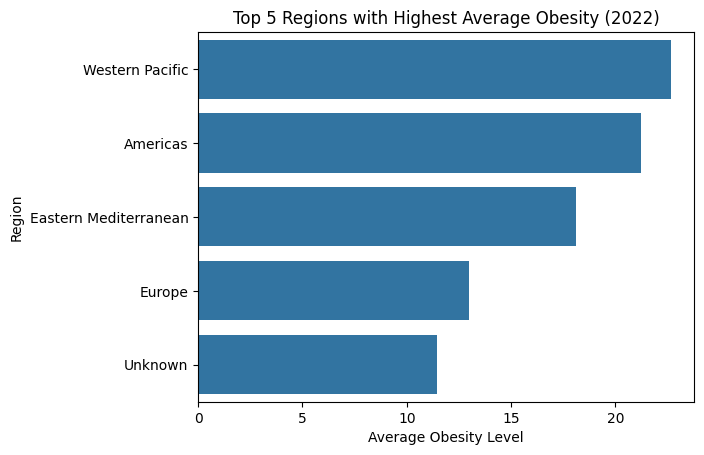

In [28]:
# Seaborn visualization for Query 1

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.barplot(
    data=df_q1,
    x="avg_obesity",
    y="Region"
)

plt.xlabel("Average Obesity Level")
plt.ylabel("Region")
plt.title("Top 5 Regions with Highest Average Obesity (2022)")
plt.show()


In [29]:
# Query 2: Top 5 countries with highest obesity estimates

q2 = """
SELECT Country,
       AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
GROUP BY Country
ORDER BY avg_obesity DESC
LIMIT 5;
"""

df_q2 = pd.read_sql(q2, conn)
df_q2


,Country,avg_obesity
0,Niue,40.664873
1,Cook Islands,39.917173
2,Nauru,38.512101
3,Tokelau,37.960966
4,American Samoa,36.892015


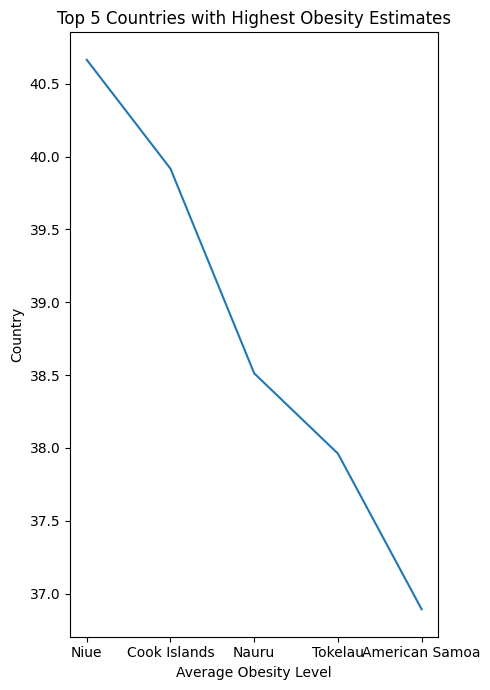

In [30]:
# Seaborn visualization for Query 2

plt.figure(figsize=(5, 7))
sns.lineplot(
    data=df_q2,
    y="avg_obesity",
    x="Country"
)

plt.xlabel("Average Obesity Level")
plt.ylabel("Country")
plt.title("Top 5 Countries with Highest Obesity Estimates")
plt.tight_layout()
plt.show()


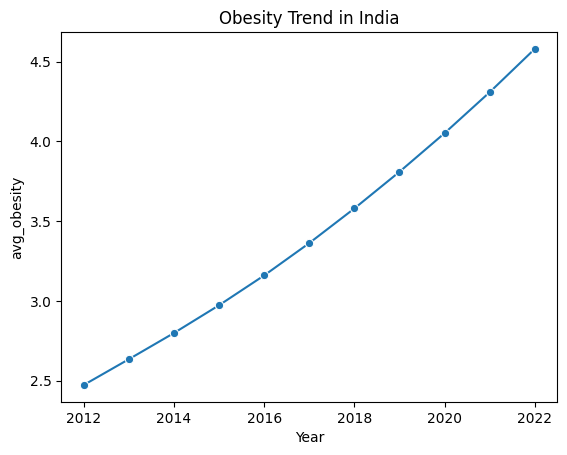

In [31]:
# Query 3: Obesity trend in India over the years 2012 to 2022

q3 = """
SELECT Year,
       AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
WHERE Country = 'India'
GROUP BY Year
ORDER BY Year;
"""

df_q3 = pd.read_sql(q3, conn)

sns.lineplot(data=df_q3, x="Year", y="avg_obesity", marker="o")
plt.title("Obesity Trend in India")
plt.show()


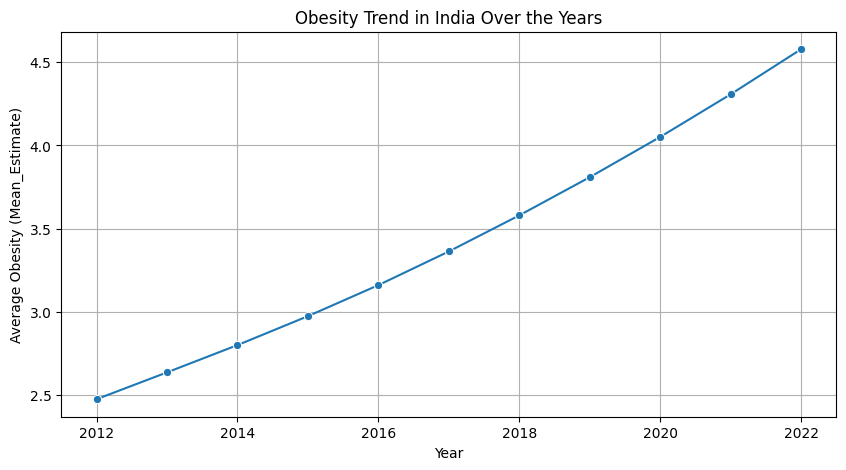

In [32]:
# Query 3: Obesity trend in India over the years (Mean_Estimate)

query_3 = """
SELECT
    Year,
    AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
WHERE Country = 'India'
GROUP BY Year
ORDER BY Year;
"""

# Read query result into DataFrame
df_q3 = pd.read_sql(query_3, conn)

# Plot using Seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_q3, x="Year", y="avg_obesity", marker="o")

plt.title("Obesity Trend in India Over the Years")
plt.xlabel("Year")
plt.ylabel("Average Obesity (Mean_Estimate)")
plt.grid(True)

plt.show()


In [33]:
#Query 4: Average obesity by gender (Male, Female, Both)

import seaborn as sns
import matplotlib.pyplot as plt

query_gender = """
SELECT
    Gender,
    AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
WHERE Gender IN ('Male', 'Female', 'Both')
GROUP BY Gender
ORDER BY avg_obesity DESC;
"""

df_gender = pd.read_sql(query_gender, conn)
df_gender


,Gender,avg_obesity
0,Both,12.781969
1,Male,12.776696
2,Female,12.724456


/tmp/ipython-input-2282177948.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


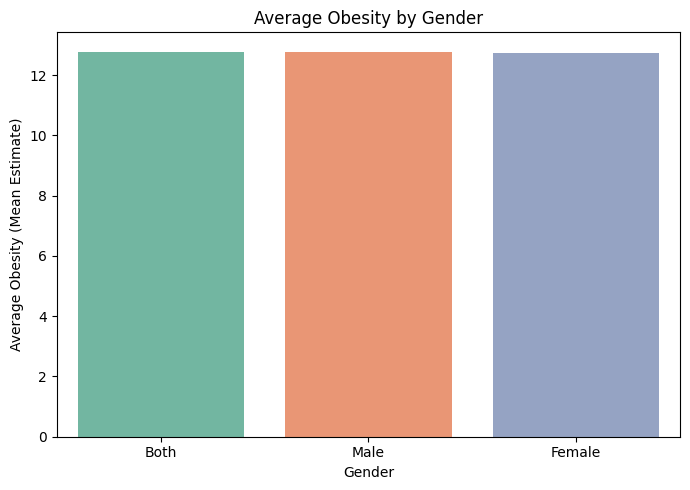

In [34]:
plt.figure(figsize=(7,5))

sns.barplot(
    data=df_gender,
    x="Gender",
    y="avg_obesity",
    palette="Set2"
)

plt.title("Average Obesity by Gender")
plt.xlabel("Gender")
plt.ylabel("Average Obesity (Mean Estimate)")
plt.tight_layout()
plt.show()


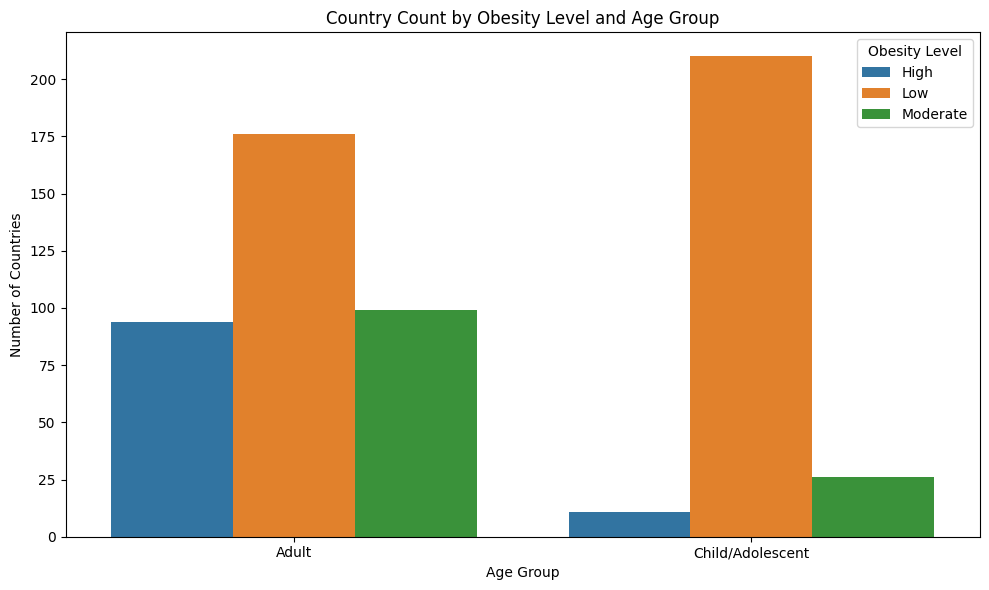

In [35]:
# Query 5: Country count by obesity level category and age group

query_5 = """
SELECT
    Obesity_Level,
    age_group,
    COUNT(DISTINCT Country) AS country_count
FROM obesity_powerbi
GROUP BY Obesity_Level, age_group;
"""

df_q5 = pd.read_sql(query_5, conn)

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_q5,
    x="age_group",
    y="country_count",
    hue="Obesity_Level"
)

plt.title("Country Count by Obesity Level and Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Countries")
plt.legend(title="Obesity Level")
plt.tight_layout()
plt.show()


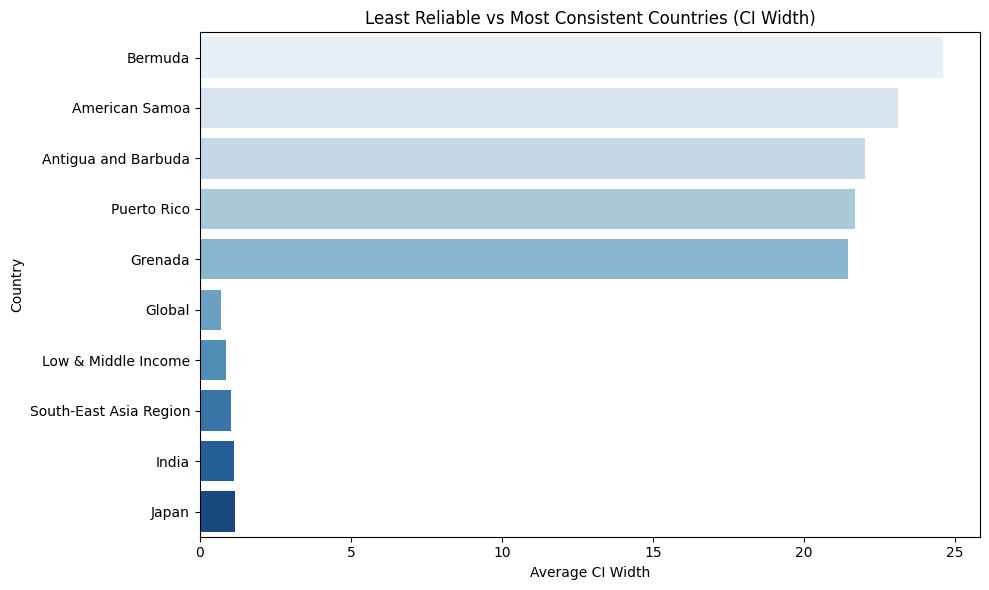

In [36]:
# Query 6:
# Top 5 least reliable countries (highest avg CI_Width)
# Top 5 most consistent countries (lowest avg CI_Width)

import matplotlib.pyplot as plt
import seaborn as sns

query_6 = """
SELECT
    Country,
    AVG(CI_Width) AS avg_ci_width
FROM obesity_powerbi
GROUP BY Country
"""

df_q6 = pd.read_sql(query_6, conn)

# Top 5 highest CI_Width (least reliable)
top_5_high_ci = df_q6.sort_values("avg_ci_width", ascending=False).head(5)

# Top 5 lowest CI_Width (most consistent)
top_5_low_ci = df_q6.sort_values("avg_ci_width", ascending=True).head(5)

# Combine both
df_q6_plot = pd.concat([top_5_high_ci, top_5_low_ci])

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_q6_plot,
    x="avg_ci_width",
    y="Country",
    hue="Country",
    palette="Blues",
    legend=False
)

plt.title("Least Reliable vs Most Consistent Countries (CI Width)")
plt.xlabel("Average CI Width")
plt.ylabel("Country")
plt.tight_layout()
plt.show()
#CI Width represents the uncertainty range of the obesity estimate. Smaller CI Width means more reliable data,
# while larger CI Width indicates higher variability and lower confidence.


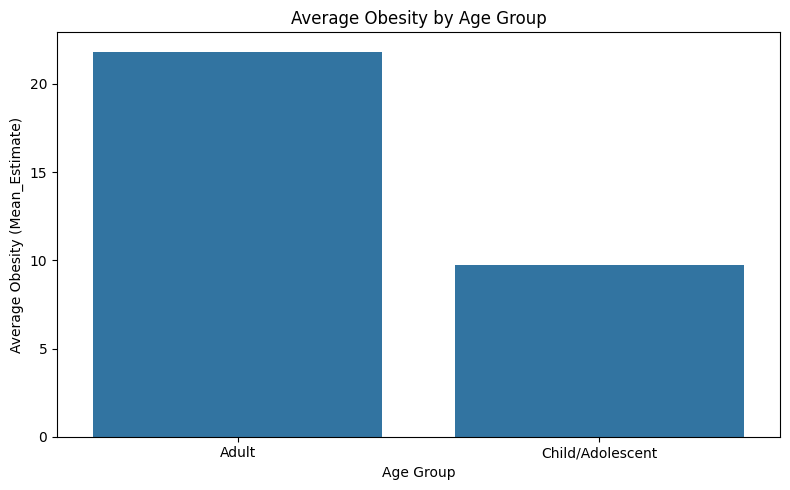

In [37]:
# Query 7: Average obesity by age group

query_7 = """
SELECT
    age_group,
    AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
GROUP BY age_group
ORDER BY avg_obesity DESC;
"""

df_q7 = pd.read_sql(query_7, conn)

# Seaborn bar plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_q7,
    x="age_group",
    y="avg_obesity"
)

plt.title("Average Obesity by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average Obesity (Mean_Estimate)")
plt.tight_layout()
plt.show()


In [38]:
# Query 8: Top 10 Countries with consistent low obesity (low average + low CI)

query_8_sql = """
SELECT
    Country,
    AVG(Mean_Estimate) AS avg_obesity,
    AVG(CI_Width) AS avg_ci
FROM obesity_powerbi
GROUP BY Country
HAVING avg_obesity < 10 AND avg_ci < 5
ORDER BY avg_obesity ASC
LIMIT 10;
"""

query_8 = pd.read_sql(query_8_sql, conn)
query_8


,Country,avg_obesity,avg_ci
0,Timor-Leste,0.994067,1.273569
1,Ethiopia,1.491994,1.589414
2,Burkina Faso,1.721496,1.531514
3,Rwanda,1.767194,2.360579
4,Bangladesh,1.976673,1.663506
5,Madagascar,1.984110,4.356885
6,Malawi,2.391324,2.632714
7,Nepal,2.494255,3.098051
8,Mozambique,2.772243,2.764629
9,Niger,3.080740,4.666968


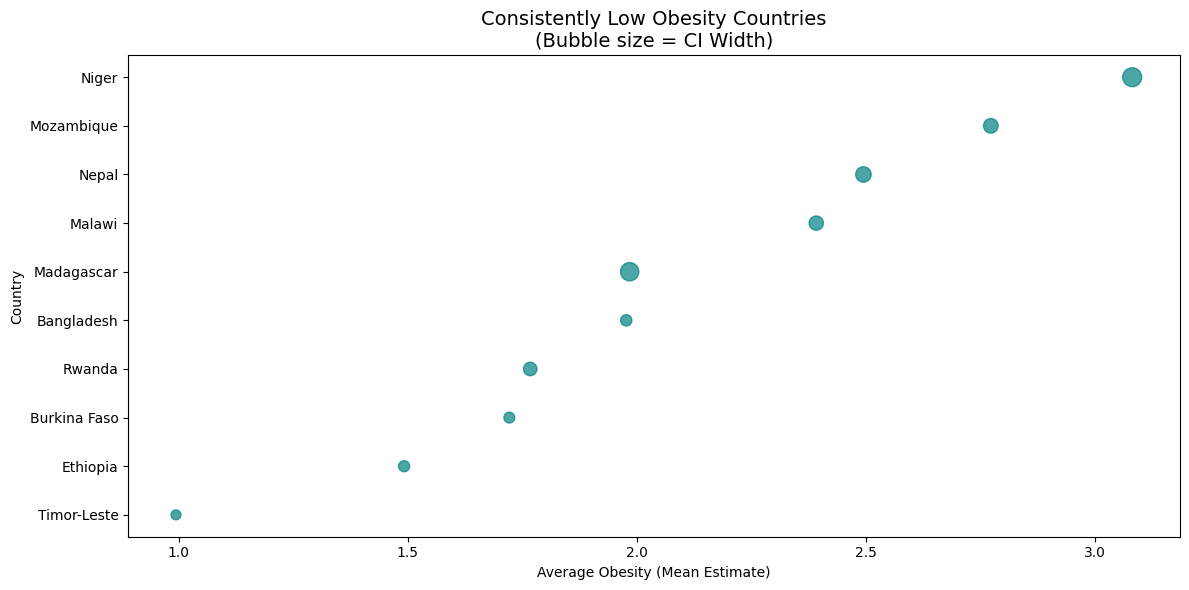

In [39]:
plt.figure(figsize=(12,6))

plt.scatter(
    x=query_8["avg_obesity"],
    y=query_8["Country"],
    s=query_8["avg_ci"] * 40,   # bubble size = CI width
    alpha=0.7,
    color="teal"
)

plt.title("Consistently Low Obesity Countries\n(Bubble size = CI Width)", fontsize=14)
plt.xlabel("Average Obesity (Mean Estimate)")
plt.ylabel("Country")

plt.tight_layout()
plt.show()


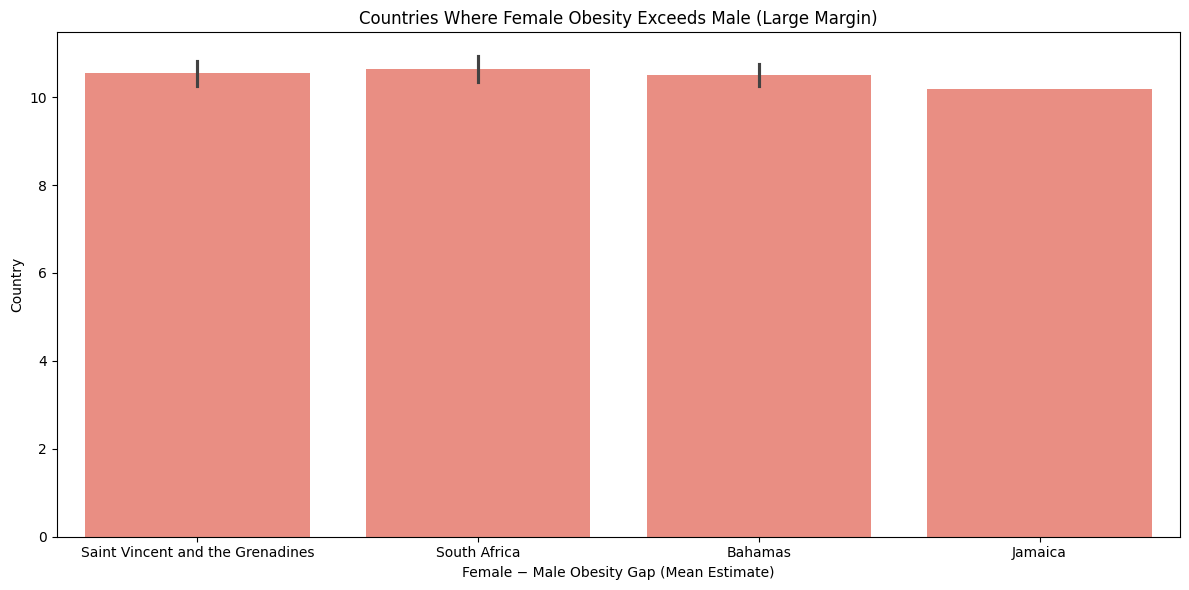

In [40]:
# Query 9: Countries where female obesity exceeds male obesity by a large margin (same year)

query_9 = """
SELECT
    Country,
    Year,
    AVG(CASE WHEN Gender = 'Female' THEN Mean_Estimate END) AS female_obesity,
    AVG(CASE WHEN Gender = 'Male' THEN Mean_Estimate END) AS male_obesity,
    (AVG(CASE WHEN Gender = 'Female' THEN Mean_Estimate END) -
     AVG(CASE WHEN Gender = 'Male' THEN Mean_Estimate END)) AS obesity_gap
FROM obesity_powerbi
GROUP BY Country, Year
HAVING obesity_gap IS NOT NULL
   AND obesity_gap > 5
ORDER BY obesity_gap DESC
LIMIT 10;
"""

df_q9 = pd.read_sql(query_9, conn)

# Plot using Seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_q9,
    x="Country",
    y="obesity_gap",
    color="salmon"
)

plt.title("Countries Where Female Obesity Exceeds Male (Large Margin)")
plt.xlabel("Female − Male Obesity Gap (Mean Estimate)")
plt.ylabel("Country")

plt.tight_layout()
plt.show()


In [41]:
# Query 9 (Modified):
# Countries with large obesity variation over years (max - min)

query_9 = """
SELECT
    Country,
    MAX(Mean_Estimate) - MIN(Mean_Estimate) AS obesity_variation
FROM obesity_powerbi
GROUP BY Country
HAVING obesity_variation > 5
ORDER BY obesity_variation DESC
LIMIT 10;
"""

df_q9 = pd.read_sql(query_9, conn)
df_q9


,Country,obesity_variation
0,American Samoa,69.872773
1,Tonga,61.650150
2,Samoa,61.579215
3,Nauru,57.511939
4,Tuvalu,57.412850
5,Tokelau,57.103929
6,Cook Islands,56.728450
7,Niue,51.542111
8,Kiribati,48.586033
9,Marshall Islands,48.244784


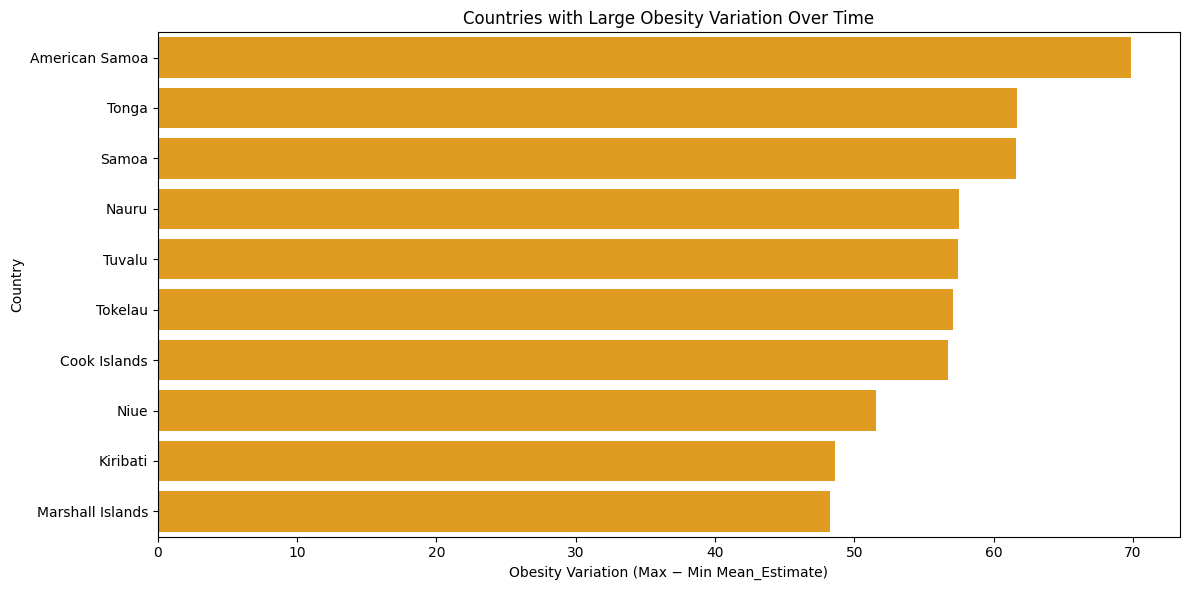

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))

sns.barplot(
    data=df_q9,
    y="Country",
    x="obesity_variation",
    color="orange"
)

plt.title("Countries with Large Obesity Variation Over Time")
plt.xlabel("Obesity Variation (Max − Min Mean_Estimate)")
plt.ylabel("Country")

plt.tight_layout()
plt.show()


In [43]:
# Query 10:
# Global average obesity percentage per year

query_10 = """
SELECT
    Year,
    AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
GROUP BY Year
ORDER BY Year;
"""

df_q10 = pd.read_sql(query_10, conn)
df_q10


,Year,avg_obesity
0,2012,11.061969
1,2013,11.359637
2,2014,11.670343
3,2015,11.994231
4,2016,12.333907
5,2017,12.689997
6,2018,13.060296
7,2019,13.444604
8,2020,13.843002
9,2021,14.250923


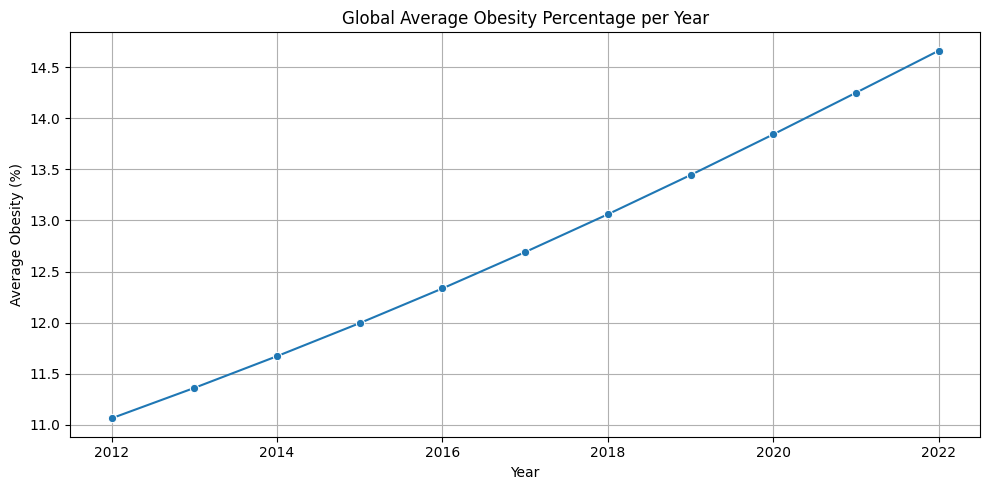

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))

sns.lineplot(
    data=df_q10,
    x="Year",
    y="avg_obesity",
    marker="o"
)

plt.title("Global Average Obesity Percentage per Year")
plt.xlabel("Year")
plt.ylabel("Average Obesity (%)")

plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:
# World map data: Average obesity by country

q_map_obesity = """
SELECT
    Country,
    AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
GROUP BY Country;
"""

df_map = pd.read_sql(q_map_obesity, conn)
df_map.head()


,Country,avg_obesity
0,Afghanistan,7.763365
1,Africa,4.672290
2,Albania,10.947071
3,Algeria,15.051907
4,American Samoa,36.892015


In [ ]:
#To visualize country-wise obesity levels geographically, helping identify regional and global patterns.

In [46]:
import plotly.express as px

fig = px.choropleth(
    df_map,
    locations="Country",          # country names
    locationmode="country names",
    color="avg_obesity",          # value to color
    color_continuous_scale="Reds",
    title="Global Average Obesity Levels by Country",
    labels={"avg_obesity": "Average Obesity (%)"}
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
    coloraxis_colorbar=dict(title="Obesity %")
)

fig.show()


#Malnutrition

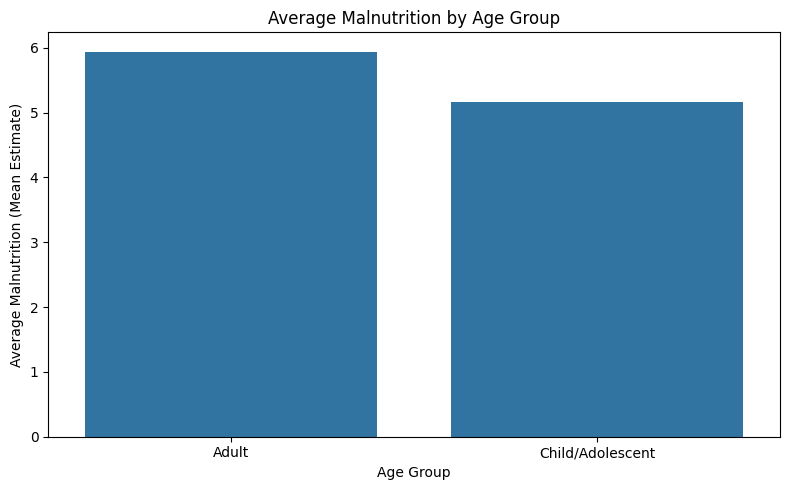

In [47]:
# Query 1: Average malnutrition by age_group

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

q1 = """
SELECT age_group, AVG(mean_estimate) AS avg_malnutrition
FROM malnutrition_powerbi
GROUP BY age_group
ORDER BY avg_malnutrition DESC;
"""

df_q1 = pd.read_sql(q1, conn)

plt.figure(figsize=(8,5))
sns.barplot(
    data=df_q1,
    x="age_group",
    y="avg_malnutrition"
)

plt.title("Average Malnutrition by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average Malnutrition (Mean Estimate)")
plt.tight_layout()
plt.show()


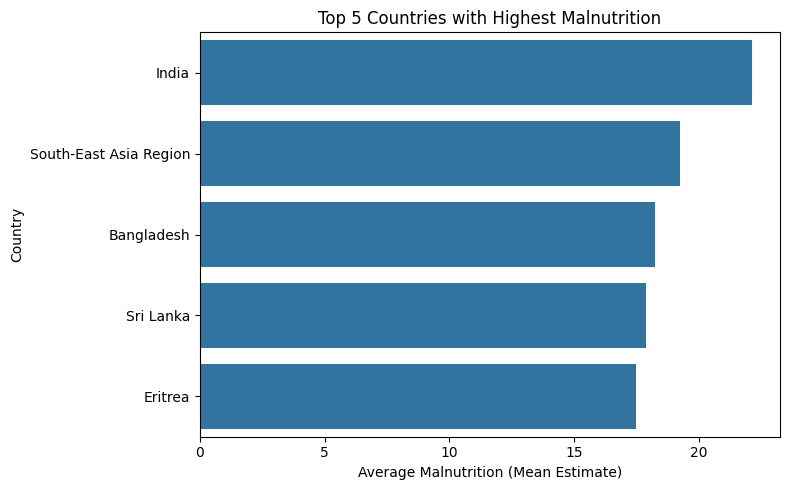

In [48]:
# Query 2: Top 5 countries with highest malnutrition (mean_estimate)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

q2 = """
SELECT
    Country,
    AVG(mean_estimate) AS avg_malnutrition
FROM malnutrition_powerbi
GROUP BY Country
ORDER BY avg_malnutrition DESC
LIMIT 5;
"""

df_q2 = pd.read_sql(q2, conn)

plt.figure(figsize=(8,5))
sns.barplot(
    data=df_q2,
    x="avg_malnutrition",
    y="Country"
)

plt.title("Top 5 Countries with Highest Malnutrition")
plt.xlabel("Average Malnutrition (Mean Estimate)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


In [49]:
#Query 3: Malnutrition trend in African region over the years

q_africa = """
SELECT
    Year,
    AVG(mean_estimate) AS avg_malnutrition
FROM malnutrition_powerbi
WHERE Region = 'Africa'
GROUP BY Year
ORDER BY Year;
"""

df_africa = pd.read_sql(q_africa, conn)
df_africa.head()


,Year,avg_malnutrition
0,2012,8.849655
1,2013,8.749857
2,2014,8.662762
3,2015,8.587719
4,2016,8.523125


In [50]:
import plotly.express as px

fig = px.area(
    df_africa,
    x="Year",
    y="avg_malnutrition",
    title="Malnutrition Trend in African Region Over the Years",
    labels={
        "avg_malnutrition": "Average Malnutrition (%)",
        "Year": "Year"
    }
)

fig.update_traces(
    mode="lines+markers",
    line=dict(width=3),
    marker=dict(size=6)
)

fig.update_layout(
    template="plotly_white",
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    hovermode="x unified"
)

fig.show()


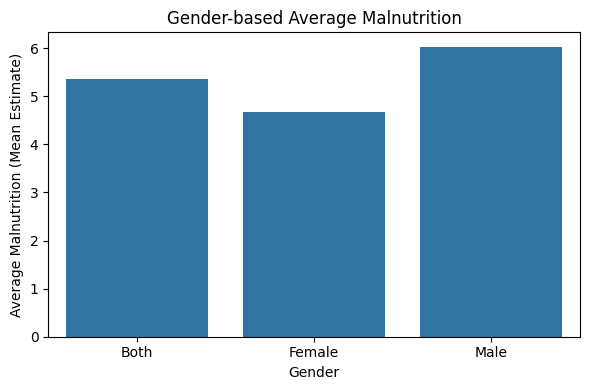

In [51]:
# Query 4: Gender-based average malnutrition

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

q4 = """
SELECT
    Gender,
    AVG(mean_estimate) AS avg_malnutrition
FROM malnutrition_powerbi
GROUP BY Gender;
"""

df_q4 = pd.read_sql(q4, conn)

plt.figure(figsize=(6,4))
sns.barplot(
    data=df_q4,
    x="Gender",
    y="avg_malnutrition"
)

plt.title("Gender-based Average Malnutrition")
plt.xlabel("Gender")
plt.ylabel("Average Malnutrition (Mean Estimate)")
plt.tight_layout()
plt.show()


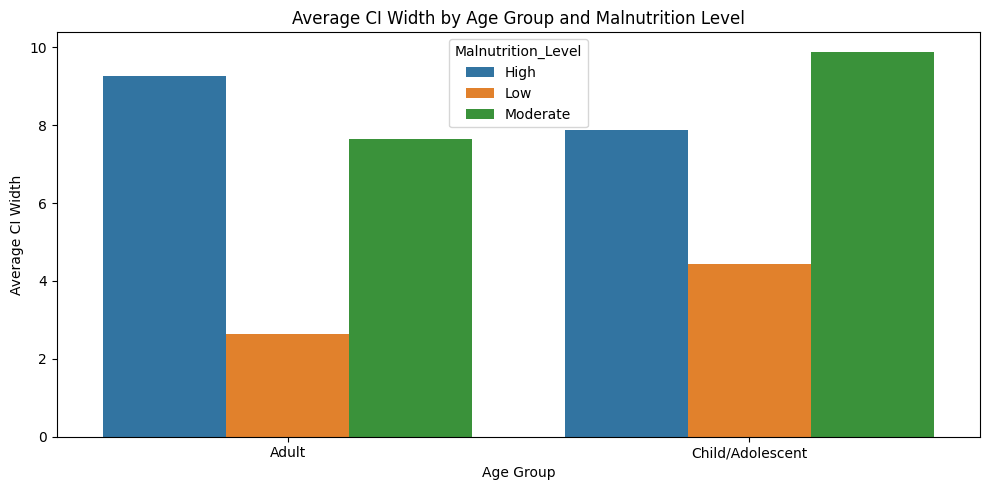

In [52]:
# Query 5: Malnutrition level-wise average CI_Width by age_group (FIXED)

import seaborn as sns
import matplotlib.pyplot as plt

q5 = """
SELECT
    age_group,
    Malnutrition_Level,
    AVG(CI_Width) AS avg_ci_width
FROM malnutrition_powerbi
GROUP BY age_group, Malnutrition_Level
ORDER BY age_group;
"""

df_q5 = pd.read_sql(q5, conn)

plt.figure(figsize=(10,5))
sns.barplot(
    data=df_q5,
    x="age_group",
    y="avg_ci_width",
    hue="Malnutrition_Level"
)

plt.title("Average CI Width by Age Group and Malnutrition Level")
plt.xlabel("Age Group")
plt.ylabel("Average CI Width")
plt.tight_layout()
plt.show()


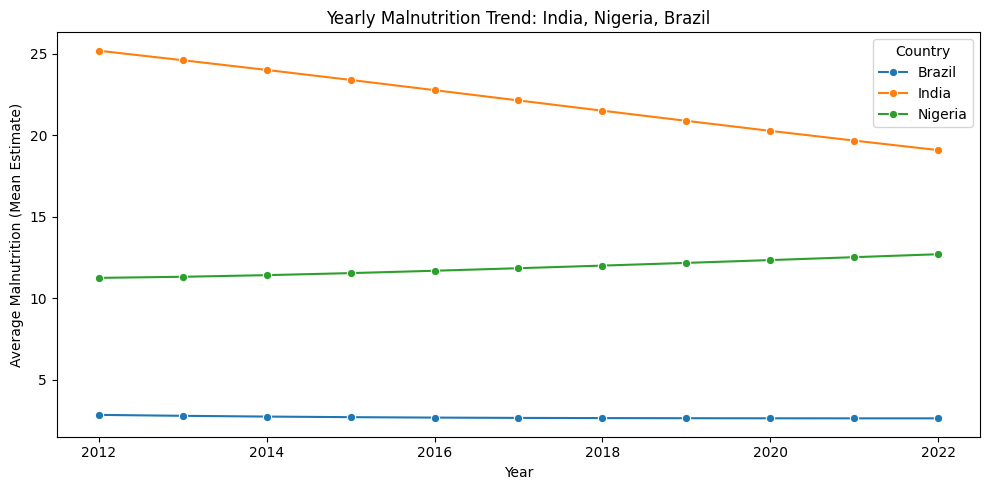

In [53]:
# Query 6: Yearly malnutrition change in India, Nigeria, Brazil

q6 = """
SELECT
    Country,
    Year,
    AVG(mean_estimate) AS avg_malnutrition
FROM malnutrition_powerbi
WHERE Country IN ('India', 'Nigeria', 'Brazil')
GROUP BY Country, Year
ORDER BY Country, Year;
"""

df_q6 = pd.read_sql(q6, conn)

plt.figure(figsize=(10,5))
sns.lineplot(
    data=df_q6,
    x="Year",
    y="avg_malnutrition",
    hue="Country",
    marker="o"
)

plt.title("Yearly Malnutrition Trend: India, Nigeria, Brazil")
plt.xlabel("Year")
plt.ylabel("Average Malnutrition (Mean Estimate)")
plt.tight_layout()
plt.show()


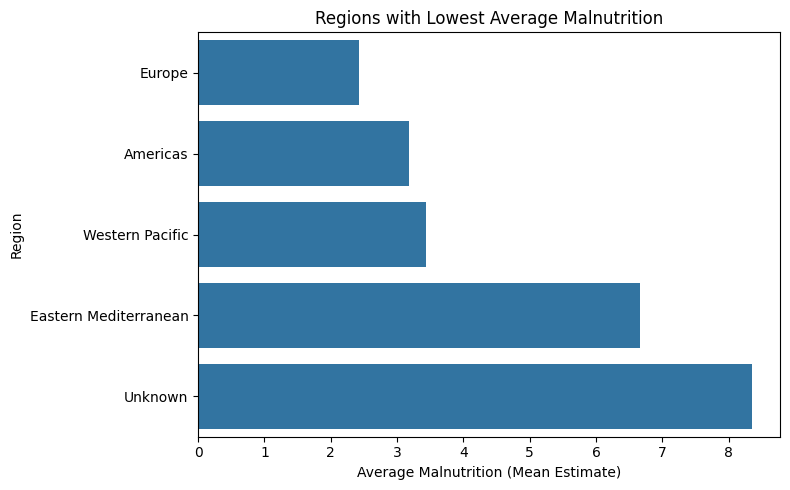

In [54]:
# Query 7: Regions with lowest malnutrition averages

q7 = """
SELECT
    Region,
    AVG(mean_estimate) AS avg_malnutrition
FROM malnutrition_powerbi
GROUP BY Region
ORDER BY avg_malnutrition ASC
LIMIT 5;
"""

df_q7 = pd.read_sql(q7, conn)

plt.figure(figsize=(8,5))
sns.barplot(
    data=df_q7,
    x="avg_malnutrition",
    y="Region"
)

plt.title("Regions with Lowest Average Malnutrition")
plt.xlabel("Average Malnutrition (Mean Estimate)")
plt.ylabel("Region")
plt.tight_layout()
plt.show()


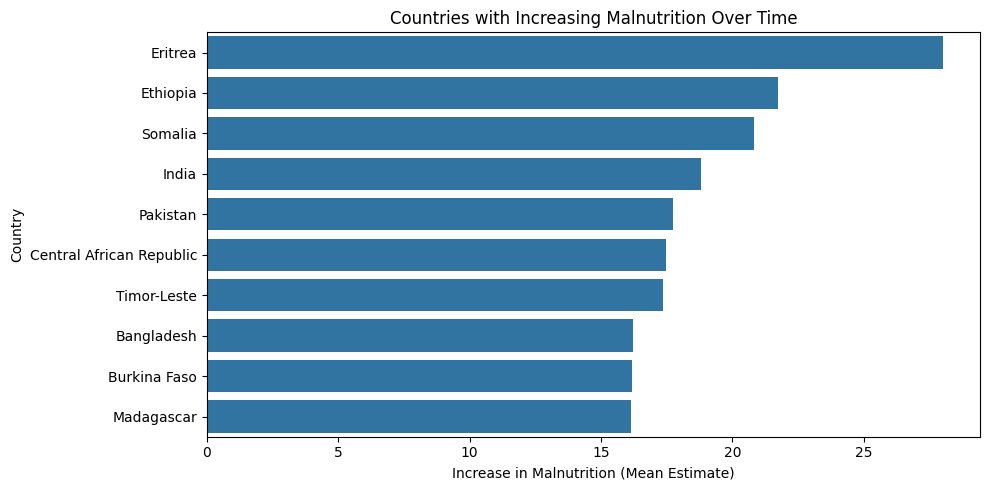

In [55]:
# Query 8: Countries with increasing malnutrition over time

q8 = """
SELECT
    Country,
    MIN(mean_estimate) AS early_malnutrition,
    MAX(mean_estimate) AS recent_malnutrition,
    (MAX(mean_estimate) - MIN(mean_estimate)) AS change_value
FROM malnutrition_powerbi
GROUP BY Country
HAVING change_value > 0
ORDER BY change_value DESC
LIMIT 10;
"""

df_q8 = pd.read_sql(q8, conn)

plt.figure(figsize=(10,5))
sns.barplot(
    data=df_q8,
    x="change_value",
    y="Country"
)

plt.title("Countries with Increasing Malnutrition Over Time")
plt.xlabel("Increase in Malnutrition (Mean Estimate)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


In [56]:
# Query 9: Min and Max malnutrition levels per year (latest year pie chart)

q9 = """
SELECT
    Year,
    MIN(mean_estimate) AS min_malnutrition,
    MAX(mean_estimate) AS max_malnutrition
FROM malnutrition_powerbi
GROUP BY Year
ORDER BY Year DESC
LIMIT 1;
"""

df_q9 = pd.read_sql(q9, conn)
df_q9


,Year,min_malnutrition,max_malnutrition
0,2022,0.188174,34.261948


In [57]:
labels = ["Minimum Malnutrition", "Maximum Malnutrition"]
values = [
    df_q9.loc[0, "min_malnutrition"],
    df_q9.loc[0, "max_malnutrition"]
]


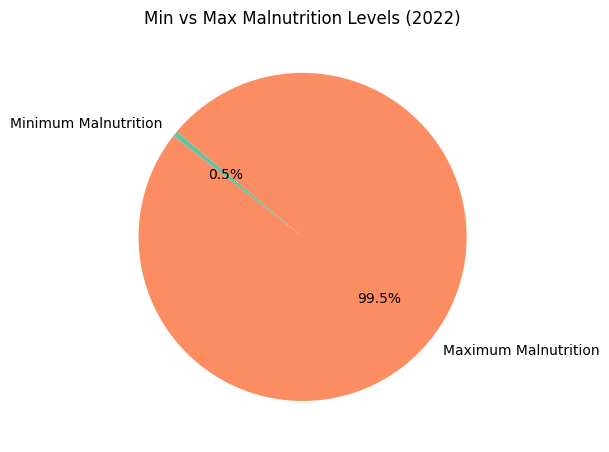

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))

plt.pie(
    values,
    labels=labels,
    autopct="%1.1f%%",
    startangle=140,
    colors=["#66c2a5", "#fc8d62"]
)

plt.title(
    f"Min vs Max Malnutrition Levels ({int(df_q9.loc[0,'Year'])})"
)

plt.tight_layout()
plt.show()


In [59]:
# Query 10: High CI_Width flags (CI_Width > 5)

q10 = """
SELECT
    Country,
    Year,
    CI_Width
FROM malnutrition_powerbi
WHERE CI_Width > 5
ORDER BY CI_Width DESC;
"""

df_q10 = pd.read_sql(q10, conn)
df_q10.head()


,Country,Year,CI_Width
0,Senegal,2022,26.701744
1,Senegal,2022,26.701744
2,Senegal,2021,25.679344
3,Senegal,2021,25.679344
4,Senegal,2020,24.586366


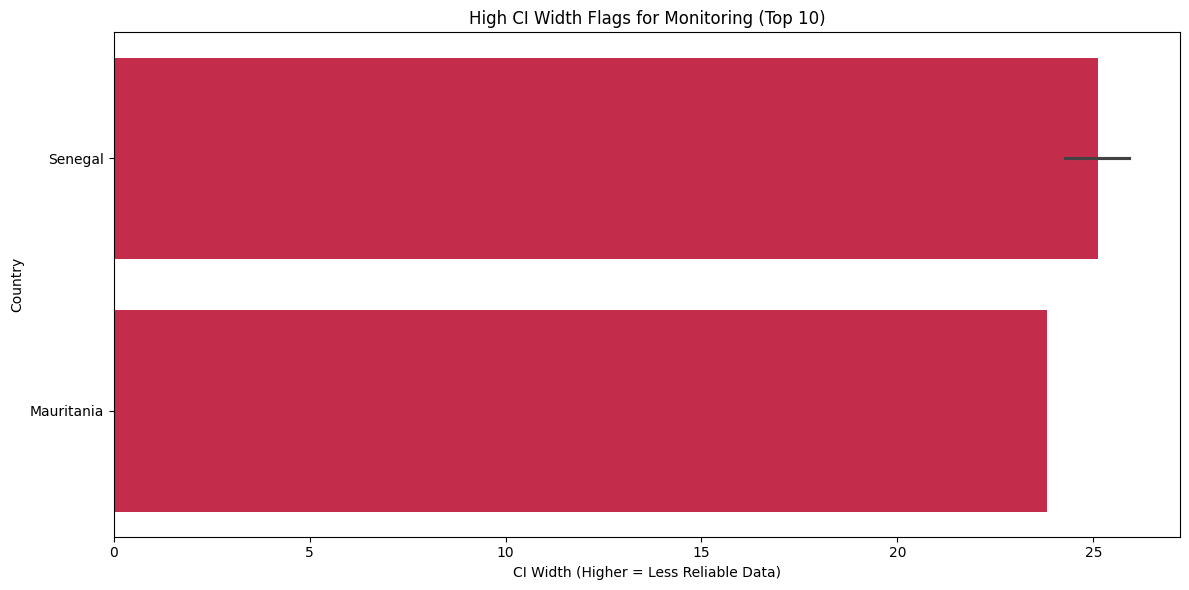

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Take top 10 highest CI_Width for clarity
df_q10_plot = df_q10.sort_values("CI_Width", ascending=False).head(10)

plt.figure(figsize=(12,6))

sns.barplot(
    data=df_q10_plot,
    x="CI_Width",
    y="Country",
    color="crimson"
)

plt.title("High CI Width Flags for Monitoring (Top 10)")
plt.xlabel("CI Width (Higher = Less Reliable Data)")
plt.ylabel("Country")

plt.tight_layout()
plt.show()


#Combined queries

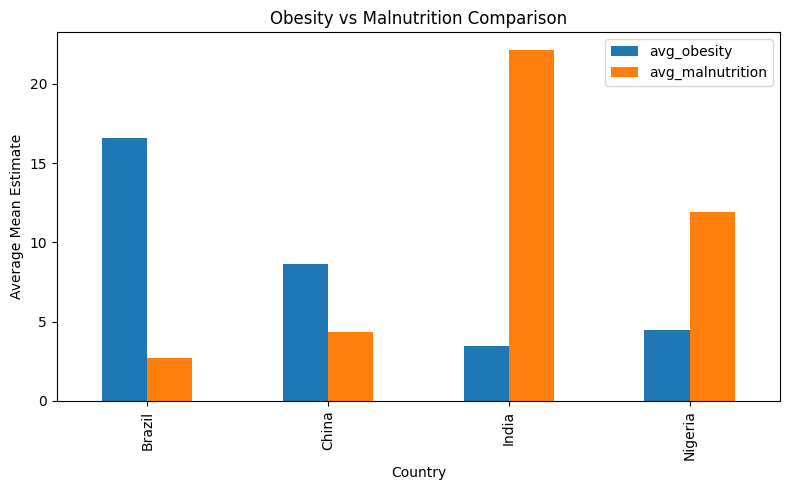

In [61]:
# Combined Query 1: Obesity vs Malnutrition comparison by country

q_c1 = """
SELECT
    o.Country,
    AVG(o.Mean_Estimate) AS avg_obesity,
    AVG(m.mean_estimate) AS avg_malnutrition
FROM obesity_powerbi o
JOIN malnutrition_powerbi m
ON o.Country = m.Country
WHERE o.Country IN ('India','USA','Brazil','Nigeria','China')
GROUP BY o.Country;
"""

df_c1 = pd.read_sql(q_c1, conn)

df_c1.plot(
    x="Country",
    kind="bar",
    figsize=(8,5),
    title="Obesity vs Malnutrition Comparison"
)

plt.ylabel("Average Mean Estimate")
plt.tight_layout()
plt.show()


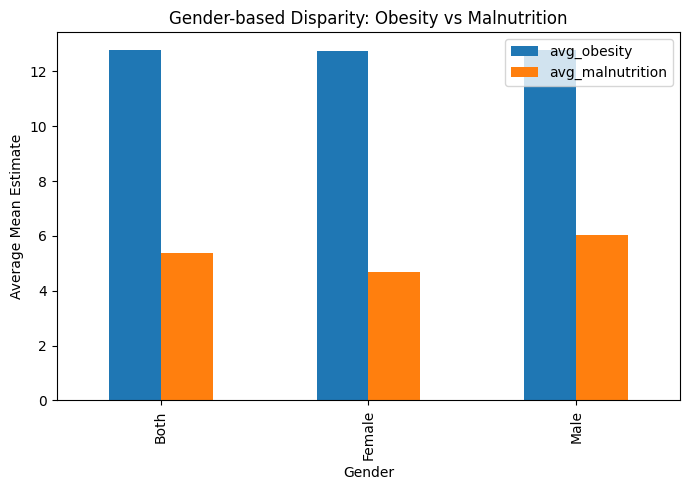

In [62]:
# Combined Query 2 (FIXED): Gender-based disparity in both obesity and malnutrition

q_c2 = """
SELECT
    o.Gender AS Gender,
    AVG(o.Mean_Estimate) AS avg_obesity,
    AVG(m.mean_estimate) AS avg_malnutrition
FROM obesity_powerbi o
JOIN malnutrition_powerbi m
ON o.Country = m.Country
AND o.Year = m.Year
AND o.Gender = m.Gender
GROUP BY o.Gender;
"""

df_c2 = pd.read_sql(q_c2, conn)

df_c2.plot(
    x="Gender",
    kind="bar",
    figsize=(7,5),
    title="Gender-based Disparity: Obesity vs Malnutrition"
)

plt.ylabel("Average Mean Estimate")
plt.tight_layout()
plt.show()


In [63]:
# Combined Query 3: Region-wise average estimates (Africa vs Americas)

q_c3 = """
SELECT
    Region,
    AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
WHERE Region IN ('Africa', 'Americas')
GROUP BY Region;
"""

df_region = pd.read_sql(q_c3, conn)
df_region


,Region,avg_obesity
0,Africa,5.415204
1,Americas,18.402103


In [64]:
# Get country-wise data for Africa & Americas

q_map_region = """
SELECT
    Country,
    Region,
    AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
WHERE Region IN ('Africa', 'Americas')
GROUP BY Country, Region;
"""

df_map_region = pd.read_sql(q_map_region, conn)
df_map_region.head()


,Country,Region,avg_obesity
0,Algeria,Africa,15.051907
1,Angola,Africa,4.758767
2,Antigua and Barbuda,Americas,24.229991
3,Argentina,Americas,19.447073
4,Bahamas,Americas,29.402310


In [65]:
import plotly.express as px

fig = px.choropleth(
    df_map_region,
    locations="Country",
    locationmode="country names",
    color="avg_obesity",
    facet_col="Region",                 # 🔥 Africa vs Americas side-by-side
    color_continuous_scale="OrRd",
    title="Region-wise Average Obesity Levels: Africa vs Americas",
    labels={"avg_obesity": "Average Obesity (%)"}
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
    coloraxis_colorbar=dict(title="Obesity %")
)

fig.show()


In [66]:
# Combined Query 4: Obesity up & malnutrition down

q_c4 = """
SELECT
    o.Country,
    (MAX(o.Mean_Estimate) - MIN(o.Mean_Estimate)) AS obesity_change,
    (MAX(m.mean_estimate) - MIN(m.mean_estimate)) AS malnutrition_change
FROM obesity_powerbi o
JOIN malnutrition_powerbi m
    ON o.Country = m.Country
GROUP BY o.Country
HAVING obesity_change > 0 AND malnutrition_change < 0;
"""

df_c4 = pd.read_sql(q_c4, conn)
df_c4.head()


,Country,obesity_change,malnutrition_change


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))

sns.scatterplot(
    data=df_c4,
    x="obesity_change",
    y="malnutrition_change",
    s=100,
    color="purple"
)

# Quadrant reference lines
plt.axhline(0, color="black", linestyle="--")
plt.axvline(0, color="black", linestyle="--")

plt.title(
    "Countries with Increasing Obesity and Decreasing Malnutrition",
    fontsize=14
)

plt.xlabel("Change in Obesity (Increase →)")
plt.ylabel("Change in Malnutrition (Decrease ↓)")

plt.tight_layout()
plt.show()


In [67]:
df_c4.shape


(0, 3)

In [68]:
#debug view for Combined Query 4
q_c4 = """
SELECT
    o.Country,
    (MAX(o.Mean_Estimate) - MIN(o.Mean_Estimate)) AS obesity_change,
    (MAX(m.mean_estimate) - MIN(m.mean_estimate)) AS malnutrition_change
FROM obesity_powerbi o
JOIN malnutrition_powerbi m
    ON o.Country = m.Country
GROUP BY o.Country
HAVING obesity_change > 0
ORDER BY obesity_change DESC
LIMIT 15;
"""

df_c4 = pd.read_sql(q_c4, conn)
df_c4


,Country,obesity_change,malnutrition_change
0,American Samoa,69.872773,0.900433
1,Tonga,61.650150,0.893908
2,Samoa,61.579215,1.472992
3,Nauru,57.511939,1.448612
4,Tuvalu,57.412850,3.026137
5,Tokelau,57.103929,1.272598
6,Cook Islands,56.728450,1.187258
7,Niue,51.542111,0.896485
8,Kiribati,48.586033,1.458298
9,Marshall Islands,48.244784,3.399414


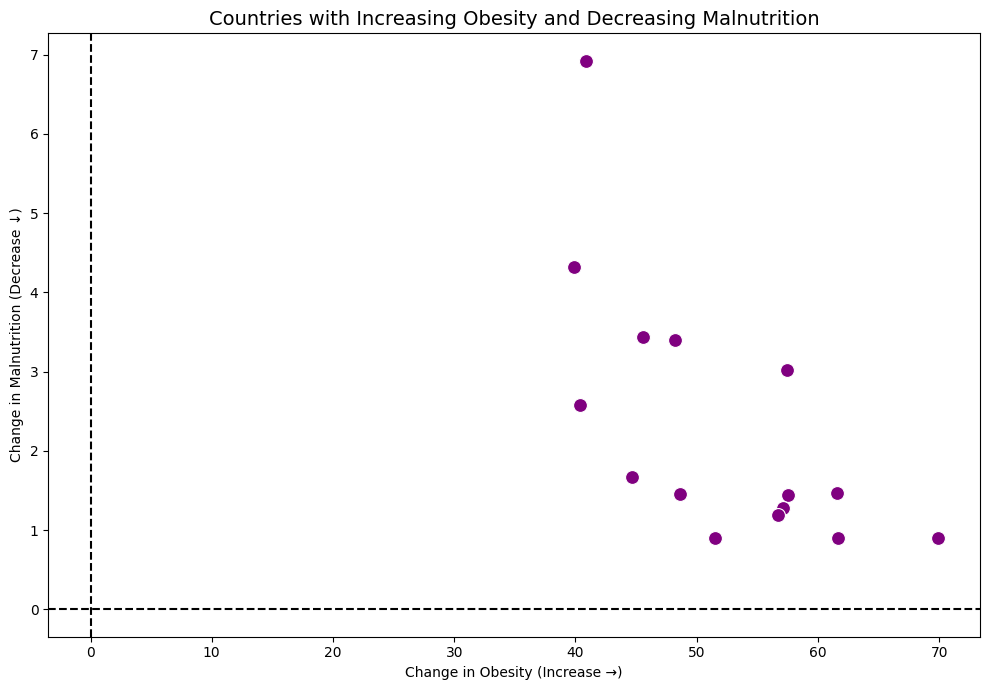

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))

sns.scatterplot(
    data=df_c4,
    x="obesity_change",
    y="malnutrition_change",
    s=100,
    color="purple"
)

# Quadrant reference lines
plt.axhline(0, color="black", linestyle="--")
plt.axvline(0, color="black", linestyle="--")

plt.title(
    "Countries with Increasing Obesity and Decreasing Malnutrition",
    fontsize=14
)

plt.xlabel("Change in Obesity (Increase →)")
plt.ylabel("Change in Malnutrition (Decrease ↓)")

plt.tight_layout()
plt.show()


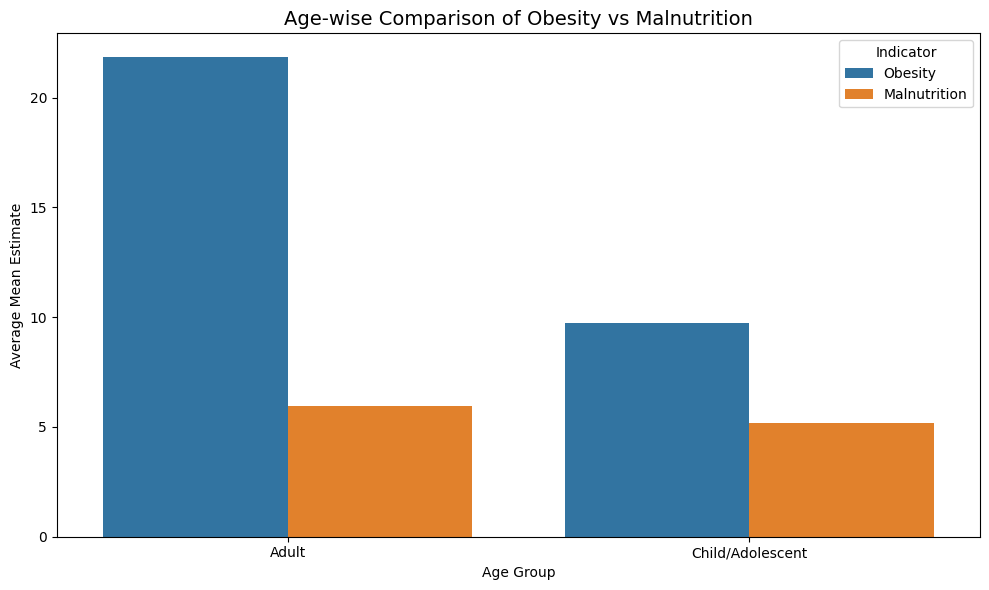

In [70]:
#Combined Query 5: Age-wise trend analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Prepare Obesity data ----
obesity_age = (
    df_obesity
    .groupby("age_group")["Mean_Estimate"]
    .mean()
    .reset_index()
)
obesity_age["Type"] = "Obesity"

# ---- Prepare Malnutrition data ----
malnutrition_age = (
    df_malnutrition
    .groupby("age_group")["Mean_Estimate"]
    .mean()
    .reset_index()
)
malnutrition_age["Type"] = "Malnutrition"

# ---- Combine ----
combined_age = pd.concat([obesity_age, malnutrition_age])

# ---- Plot (Grouped Bar Chart) ----
plt.figure(figsize=(10, 6))

sns.barplot(
    data=combined_age,
    x="age_group",
    y="Mean_Estimate",
    hue="Type"
)

plt.title("Age-wise Comparison of Obesity vs Malnutrition", fontsize=14)
plt.xlabel("Age Group")
plt.ylabel("Average Mean Estimate")
plt.legend(title="Indicator")
plt.tight_layout()
plt.show()
